In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv("AEP_hourly.csv")

In [45]:
from tensorflow.keras.utils import to_categorical
to_categorical([0, 1, 2, 3, 3, 2], num_classes=4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [46]:
data.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


нормализация

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data.AEP_MW.values.reshape(-1,1))
# print(X_train.values[0:2])
# print(X_train.values.reshape(-1,1).reshape(1,len(X_train))[0])
# print(scaler.transform(X_train.values.reshape(-1,1)).reshape(1,len(X_train))[0])
print(data.AEP_MW)

norm_data = data

norm_data.AEP_MW = scaler.transform(data.AEP_MW.values.reshape(-1,1)).reshape(1,len(data.AEP_MW.values))[0]
print(data.AEP_MW)

0         13478.0
1         12865.0
2         12577.0
3         12517.0
4         12670.0
           ...   
121268    21089.0
121269    20999.0
121270    20820.0
121271    20415.0
121272    19993.0
Name: AEP_MW, Length: 121273, dtype: float64
0         0.241839
1         0.203798
2         0.185925
3         0.182202
4         0.191697
            ...   
121268    0.714162
121269    0.708576
121270    0.697468
121271    0.672335
121272    0.646146
Name: AEP_MW, Length: 121273, dtype: float64


In [48]:
norm_data.shape

(121273, 2)

In [49]:
type(norm_data[0:2])

pandas.core.frame.DataFrame

In [50]:
def generator(data, lookback, delay, min_index, max_index=None,\
             shuffle = False, batch_size = 128, step = 5): 
    if max_index is None: 
        max_index = len(data) - delay - 1 
    i = min_index + lookback 
    while 1: 
        if shuffle: 
            rows = np.random.randint(min_index + lookback, 
                                     max_index, size=batch_size) 
        else: 
            if i + batch_size >= max_index: 
                i = min_index + lookback 
        rows = np.arange(i, min(i + batch_size, max_index)) # достаточно ли выборки для полного batch_size       
        i += len(rows)   
        
        samples = []

        targets = []
        for j, row in enumerate(rows): 
            
            indices = range(row - lookback, row, step) 
            samples.append(data[indices].reshape(lookback//step,1))

            targets.append(data[row + delay]) #[1]
        yield (np.asarray(samples), targets)

In [51]:
X_train = norm_data[0:int(len(norm_data)*0.6)]
X_val =  norm_data[(int(len(norm_data)*0.6) +1):int(len(norm_data)*0.8)]
X_test = norm_data[(int(len(norm_data)*0.8)+1):len(norm_data)]


In [52]:
print(type(X_train.AEP_MW))

<class 'pandas.core.series.Series'>


In [8]:
# best look = 32 batch = 64
lookback=4
delay=0
min_index=0
max_index=None
shuffle = False
batch_size = 16
step = 1

train_gen = generator(data=np.asarray(X_train.AEP_MW), lookback=lookback,
                             delay=delay, min_index=min_index, 
                             max_index=max_index,shuffle = shuffle, batch_size = batch_size, step = step)
val_gen = generator(data=np.asarray(X_val.AEP_MW), lookback=lookback,
                             delay=delay, min_index=min_index, 
                             max_index=max_index,shuffle = shuffle, batch_size = batch_size, step = step) 

test_gen = generator(data=np.asarray(X_test.AEP_MW), lookback=lookback,
                             delay=delay, min_index=min_index, 
                             max_index=max_index,shuffle = shuffle, batch_size = batch_size, step = step) 

In [9]:
# NB_CLASSES = 3

# model = Sequential()
# model.add(Conv1D(80, 1, activation='relu', input_shape=INPUT_SHAPE, batch_size=batch_size))
# model.add(MaxPooling1D(1))
# model.add(Conv1D(160, 1, activation='relu'))
# model.add(MaxPooling1D(1))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1))
# model.add(Activation('softmax'))
# model.summary()

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Flatten, Dense, Conv1D 
model = Sequential() 
model.add(Flatten(input_shape=(lookback // step,1))) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(15, activation='relu')) 
model.add(Dense(1)) 
model.summary() 

C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['Precision','Recall','AUC'])

In [11]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=(len(X_train.AEP_MW)//batch_size),
                             epochs=8,
                             validation_data=val_gen,
                             validation_steps=(len(X_val.AEP_MW)//batch_size))

Epoch 1/8
4547/4547 [==============================] - 28s 6ms/step - loss: 0.0019 - precision: 1.0000 - recall: 0.2348 - auc: 0.0000e+00 - val_loss: 0.0014 - val_precision: 1.0000 - val_recall: 0.1609 - val_auc: 0.0000e+00
Epoch 2/8
4547/4547 [==============================] - 27s 6ms/step - loss: 8.0794e-04 - precision: 1.0000 - recall: 0.2369 - auc: 0.0000e+00 - val_loss: 0.0013 - val_precision: 1.0000 - val_recall: 0.1605 - val_auc: 0.0000e+00
Epoch 3/8
4547/4547 [==============================] - 27s 6ms/step - loss: 7.7464e-04 - precision: 1.0000 - recall: 0.2372 - auc: 0.0000e+00 - val_loss: 0.0014 - val_precision: 1.0000 - val_recall: 0.1652 - val_auc: 0.0000e+00
Epoch 4/8
4547/4547 [==============================] - 29s 6ms/step - loss: 7.5782e-04 - precision: 1.0000 - recall: 0.2373 - auc: 0.0000e+00 - val_loss: 0.0014 - val_precision: 1.0000 - val_recall: 0.1643 - val_auc: 0.0000e+00
Epoch 5/8
4547/4547 [==============================] - 27s 6ms/step - loss: 7.4561e-04 - pre

In [31]:
print(y_test.shape)

(25000,)


In [38]:
tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)

NameError: name 'tf' is not defined

In [12]:
pred = model.predict_generator(test_gen, len(X_test.AEP_MW)//batch_size)
print(len(pred))
print(len(X_test))
print(len(norm_data["Datetime"][(int(len(norm_data)*0.8)+1):len(norm_data)]))

24240
24254
24254


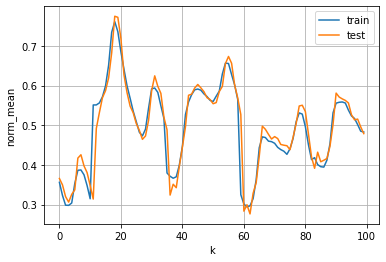

In [17]:
size = 100
plt.plot(range(size), X_test["AEP_MW"][lookback:size+lookback])
plt.plot(range(size), pred[:size])
plt.legend(['train','test'])
plt.xlabel('k')
plt.ylabel('norm_mean')
plt.grid('on')

Пример архитектуры рекуррентной сети с одним рекуррентным слоем
для прогнозирования временных рядов:

In [18]:
from tensorflow.keras.layers import GRU 
model = Sequential() 
model.add(GRU(32, input_shape = (None, 1))) 
model.add(Dense(1)) 
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['Precision','Recall','AUC'])

In [22]:
# history = model.fit(train_gen,
#                               steps_per_epoch=(len(X_train.AEP_MW)//batch_size),
#                              epochs=5,
#                              validation_data=val_gen,
#                              validation_steps=(len(X_val.AEP_MW)//batch_size))
model.fit(
    train_gen, validation_data=(val_gen), batch_size=batch_size, epochs=1,
    steps_per_epoch=len(X_train.AEP_MW)//batch_size,
    validation_steps=(len(X_val.AEP_MW)//batch_size)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4547/4547 [==============================] - 57s 12ms/step - loss: 0.0024 - precision_2: 1.0000 - recall_2: 0.2269 - auc_2: 0.0000e+00 - val_loss: 0.0011 - val_precision_2: 1.0000 - val_recall_2: 0.1332 - val_auc_2: 0.0000e+00


In [23]:
pred = model.predict_generator(test_gen, len(X_test.AEP_MW)//batch_size)

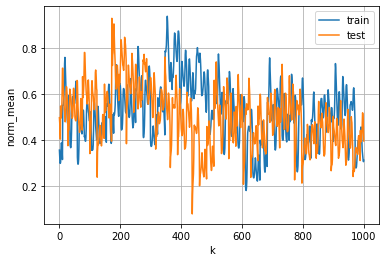

In [24]:
size = 1000
plt.plot(range(size), X_test["AEP_MW"][lookback:size+lookback])
plt.plot(range(size), pred[:size])
plt.legend(['train','test'])
plt.xlabel('k')
plt.ylabel('norm_mean')
plt.grid('on')

Пример архитектуры рекуррентной сети с двумя рекуррентными слоями
для прогнозирования временных рядов:

In [273]:
model = Sequential() 
model.add(GRU(32, 
          return_sequences = True, 
          input_shape = (None,1))) 
model.add(GRU(32, activation  = 'relu')) 
model.add(Dense(1)) 
model.summary() 

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, None, 32)          3264      
_________________________________________________________________
gru_17 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 33        
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [274]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['Precision','Recall','AUC'])

In [275]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=(len(X_train.AEP_MW)//batch_size),
                             epochs=5,
                             validation_data=val_gen,
                             validation_steps=(len(X_val.AEP_MW)//batch_size))

Epoch 1/5
4547/4547 [==============================] - 62s 14ms/step - loss: 0.0021 - precision_72: 1.0000 - recall_72: 0.2313 - auc_72: 0.0000e+00 - val_loss: 0.0013 - val_precision_72: 1.0000 - val_recall_72: 0.1568 - val_auc_72: 0.0000e+00
Epoch 2/5
4547/4547 [==============================] - 67s 15ms/step - loss: 8.0695e-04 - precision_72: 1.0000 - recall_72: 0.2356 - auc_72: 0.0000e+00 - val_loss: 0.0013 - val_precision_72: 1.0000 - val_recall_72: 0.1500 - val_auc_72: 0.0000e+00
Epoch 3/5
4547/4547 [==============================] - 62s 14ms/step - loss: 7.2811e-04 - precision_72: 1.0000 - recall_72: 0.2359 - auc_72: 0.0000e+00 - val_loss: 0.0013 - val_precision_72: 1.0000 - val_recall_72: 0.1556 - val_auc_72: 0.0000e+00
Epoch 4/5
4547/4547 [==============================] - 59s 13ms/step - loss: 6.9340e-04 - precision_72: 1.0000 - recall_72: 0.2361 - auc_72: 0.0000e+00 - val_loss: 0.0013 - val_precision_72: 1.0000 - val_recall_72: 0.1607 - val_auc_72: 0.0000e+00
Epoch 5/5
4547/4

In [277]:
pred = model.predict_generator(test_gen, len(X_test.AEP_MW)//batch_size)

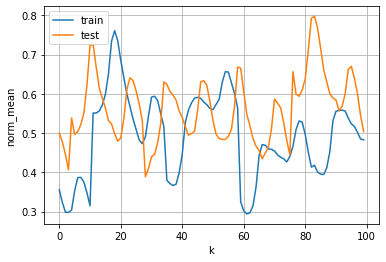

In [276]:
size = 100
plt.plot(range(size), X_test["AEP_MW"][lookback:size+lookback])
plt.plot(range(size), pred[:size])
plt.legend(['train','test'])
plt.xlabel('k')
plt.ylabel('norm_mean')
plt.grid('on')

Пример архитектуры рекуррентной сети с двумя рекуррентными слоями
с прореживанием для прогнозирования временных рядов:

In [278]:
model = Sequential() 
model.add(GRU(32,  
          dropout = 0.1, 
          recurrent_dropout = 0.5, return_sequences = True, 
          input_shape = (None, 1))) 
model.add(GRU(32, activation  = 'relu', 
          dropout = 0.1, 
          recurrent_dropout = 0.5)) 
model.add(Dense(1)) 
model.summary() 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, None, 32)          3264      
_________________________________________________________________
gru_19 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 33        
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.compile(loss='mean_absolute_error',
             optimizer='adam',
             metrics=['Precision','Recall','AUC'])

In [284]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=(len(X_train.AEP_MW)//batch_size),
                             epochs=5,
                             validation_data=val_gen,
                             validation_steps=(len(X_val.AEP_MW)//batch_size))

Epoch 1/5
4547/4547 [==============================] - 58s 13ms/step - loss: 0.0277 - precision_76: 1.0000 - recall_76: 0.2355 - auc_76: 0.0000e+00 - val_loss: 0.0459 - val_precision_76: 1.0000 - val_recall_76: 0.0504 - val_auc_76: 0.0000e+00
Epoch 2/5
4547/4547 [==============================] - 55s 12ms/step - loss: 0.0263 - precision_76: 1.0000 - recall_76: 0.2365 - auc_76: 0.0000e+00 - val_loss: 0.0488 - val_precision_76: 1.0000 - val_recall_76: 0.0489 - val_auc_76: 0.0000e+00
Epoch 3/5
4547/4547 [==============================] - 52s 11ms/step - loss: 0.0254 - precision_76: 1.0000 - recall_76: 0.2369 - auc_76: 0.0000e+00 - val_loss: 0.0511 - val_precision_76: 1.0000 - val_recall_76: 0.0445 - val_auc_76: 0.0000e+00
Epoch 4/5
4547/4547 [==============================] - 53s 12ms/step - loss: 0.0250 - precision_76: 1.0000 - recall_76: 0.2373 - auc_76: 0.0000e+00 - val_loss: 0.0498 - val_precision_76: 1.0000 - val_recall_76: 0.0427 - val_auc_76: 0.0000e+00
Epoch 5/5
4547/4547 [=======

In [287]:
pred = model.predict_generator(test_gen, len(X_test.AEP_MW)//batch_size)

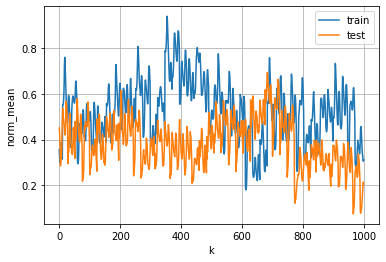

In [286]:
size = 1000
plt.plot(range(size), X_test["AEP_MW"][lookback:size+lookback])
plt.plot(range(size), pred[:+size])
plt.legend(['train','test'])
plt.xlabel('k')
plt.ylabel('norm_mean')
plt.grid('on')